# Disaster Events in and around Australia

Messing about with the [Disaster Mapper data](https://knowledge.aidr.org.au/media/10009/disaster-mapper-data-21-03-2023.xlsx)

`imports`:

In [716]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime
import geopandas as gp
import shapely
import fiona
from matplotlib.patches import Patch


matplotlib formatting:

In [717]:
%matplotlib inline

plt.rcParams["figure.figsize"] = (10, 5)

saved_style_state = matplotlib.rcParams.copy()  # give us a style state to go back to

opening data file:

In [718]:
filepath = "au-govt-agd-disaster-events-impact-location-na.csv"
disaster_data = pd.read_csv(filepath)
print("done")

done


sample of data:

In [719]:
disaster_data.head(3)

,FID,id,resourcetype,title,description,startdate,enddate,lat,lon,evacuated,...,businesses_damaged,businesses_destroyed,farms_damaged,farms_destroyed,crops_destroyed,livestock_destroyed,government_assistance,regions,url,the_geom
0,disaster_events_impact_location.fid-2393c2e0_1...,3,Disaster Event,Industrial - Appin Mine Explosion,On 24 July 1979 an explosion occurred in the u...,7/24/1979,7/24/1979,-34.192211,150.786331,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New South Wales,http://www.emknowledge.gov.au/resource/?id=3,POINT (-34.19221115 150.7863312)
1,disaster_events_impact_location.fid-2393c2e0_1...,9,Disaster Event,Transport - Trawalla Train and Truck Collision,"On 28 April 2006, a V/Line passenger train bou...",4/28/2006,4/28/2006,-37.436260,143.469421,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Victoria,http://www.emknowledge.gov.au/resource/?id=9,POINT (-37.43626022 143.4694214)
2,disaster_events_impact_location.fid-2393c2e0_1...,22,Disaster Event,Bushfire - Great Divide Complex,Victoria experienced a very adverse fire seaso...,12/01/2006,2/07/2007,-36.718010,147.145218,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Victoria,http://www.emknowledge.gov.au/resource/?id=22,POINT (-36.71800995 147.1452179)


formatting dates:

In [720]:
disaster_data.startdate = disaster_data.startdate.str.replace("/", "-")
disaster_data.enddate = disaster_data.enddate.str.replace("/", "-")

disaster_data.startdate = pd.to_datetime(disaster_data.startdate, format ='mixed', dayfirst = False)
disaster_data.startdate = disaster_data.startdate.dt.strftime('%Y-%m-%d')

disaster_data.enddate = pd.to_datetime(disaster_data.enddate, format ='mixed', dayfirst = False)
disaster_data.enddate = disaster_data.enddate.dt.strftime('%Y-%m-%d')

disaster_data.startdate.sample(5)

316    1851-06-02
588    1908-05-06
438    1998-08-13
452    1991-01-24
281    1932-07-10
Name: startdate, dtype: object

In [721]:
def robust_date_conversion(this_date):
    return datetime.strptime(this_date, '%Y-%m-%d')

def day_of_the_week(date_dt):
    return date_dt.strftime("%A")

def year(date_dt):
    return date_dt.strftime("%Y")

def duration_years(duration):
    return duration/365

disaster_data["start_dt"] = disaster_data.startdate.apply(robust_date_conversion)
disaster_data["end_dt"] = disaster_data.enddate.apply(robust_date_conversion)
disaster_data["day_of_week"] = disaster_data.start_dt.apply(day_of_the_week)
disaster_data["year"] =  disaster_data.start_dt.apply(year)
disaster_data["duration"] =  disaster_data['end_dt'] - disaster_data['start_dt']
disaster_data["duration_in_years"] = disaster_data.duration.dt.days.apply(duration_years)
disaster_data.sample(4)

,FID,id,resourcetype,title,description,startdate,enddate,lat,lon,evacuated,...,government_assistance,regions,url,the_geom,start_dt,end_dt,day_of_week,year,duration,duration_in_years
552,disaster_events_impact_location.fid-2393c2e0_1...,543,Disaster Event,Urban Fire - Brisbane Boarding House,"At approximately 11.30 pm on 18 August 2002, a...",2002-08-18,2002-08-18,-27.319187,153.071320,NaN,...,NaN,Queensland,http://www.emknowledge.gov.au/resource/?id=543,POINT (-27.31918716 153.0713196),2002-08-18,2002-08-18,Sunday,2002,0 days,0.000000
268,disaster_events_impact_location.fid-2393c2e0_1...,233,Disaster Event,Earthquake - Adelaide,"On 1 March 1954 for 20 to 30 seconds, a 5.5 Ri...",1954-03-01,1954-03-01,-34.976002,138.625488,NaN,...,NaN,South Australia,http://www.emknowledge.gov.au/resource/?id=233,POINT (-34.97600174 138.6254883),1954-03-01,1954-03-01,Monday,1954,0 days,0.000000
217,disaster_events_impact_location.fid-2393c2e0_1...,182,Disaster Event,Shipwreck - Star of Greece,The Star of Greece was a three masted ship. It...,1888-07-13,1888-07-13,-35.281502,138.416748,NaN,...,NaN,South Australia,http://www.emknowledge.gov.au/resource/?id=182,POINT (-35.28150177 138.416748),1888-07-13,1888-07-13,Friday,1888,0 days,0.000000
231,disaster_events_impact_location.fid-2393c2e0_1...,195,Disaster Event,Bushfire - Western Sydney and Central Coast,"On 16 October 1991, a number of fires erupted ...",1991-10-16,1992-01-31,-33.651207,151.001587,NaN,...,NaN,New South Wales,http://www.emknowledge.gov.au/resource/?id=195,POINT (-33.65120697 151.0015869),1991-10-16,1992-01-31,Wednesday,1991,107 days,0.293151


replacing nans with zeroes:


In [722]:
disaster_data = disaster_data.fillna(0)
disaster_data.head(3)

,FID,id,resourcetype,title,description,startdate,enddate,lat,lon,evacuated,...,government_assistance,regions,url,the_geom,start_dt,end_dt,day_of_week,year,duration,duration_in_years
0,disaster_events_impact_location.fid-2393c2e0_1...,3,Disaster Event,Industrial - Appin Mine Explosion,On 24 July 1979 an explosion occurred in the u...,1979-07-24,1979-07-24,-34.192211,150.786331,0.0,...,0.0,New South Wales,http://www.emknowledge.gov.au/resource/?id=3,POINT (-34.19221115 150.7863312),1979-07-24,1979-07-24,Tuesday,1979,0 days,0.000000
1,disaster_events_impact_location.fid-2393c2e0_1...,9,Disaster Event,Transport - Trawalla Train and Truck Collision,"On 28 April 2006, a V/Line passenger train bou...",2006-04-28,2006-04-28,-37.436260,143.469421,0.0,...,0.0,Victoria,http://www.emknowledge.gov.au/resource/?id=9,POINT (-37.43626022 143.4694214),2006-04-28,2006-04-28,Friday,2006,0 days,0.000000
2,disaster_events_impact_location.fid-2393c2e0_1...,22,Disaster Event,Bushfire - Great Divide Complex,Victoria experienced a very adverse fire seaso...,2006-12-01,2007-02-07,-36.718010,147.145218,0.0,...,0.0,Victoria,http://www.emknowledge.gov.au/resource/?id=22,POINT (-36.71800995 147.1452179),2006-12-01,2007-02-07,Friday,2006,68 days,0.186301


Disaster Events by Category:

In [723]:
disaster_data["category"] = disaster_data.apply(lambda x: x.title[0:x.title.find(" -")],axis=1)
disaster_data.category[disaster_data.category.str.contains("Cyclone")] = "Cyclone"

def cause(category):
    if category == "Tsunami" or category == "Tornado" or category == "Landslide" or category == "Earthquake" or category == "Hail" or category == "Environmental" or category == "Cyclone" or category == "Severe Storm" or category == "Bushfire" or category == "Flood":
        return str("Natural")
    elif category == "Shipwreck" or category == "Complex Emergencies":
        return str("Mixed/Either")
    else:
        return str("Man-made")

disaster_data["cause"] = disaster_data.category.apply(cause)
disaster_data[["title", "start_dt", "end_dt", "deaths", "injuries", "evacuated", "homeless", 'insured_cost', 'trains_damaged', 'trains_destroyed', 'homes_damaged', 'homes_destroyed', 'buildings_damaged', 'buildings_destroyed', 'ind_premises_destroyed', 'com_premises_damaged', 'com_premises_destroyed', 'bridges_damaged', 'bridges_destroyed', 'aircraft_damaged', 'aircraft_destroyed', 'motor_vehicles_damaged', 'motor_vehicles_destroyed', 'water_vessels_damaged', 'water_vessels_destroyed', 'businesses_damaged', 'businesses_destroyed', 'farms_damaged', 'farms_destroyed', 'crops_destroyed', 'livestock_destroyed', 'government_assistance', "regions", "cause"]].head()


C:\Users\rishi\AppData\Local\Temp\ipykernel_32336\2992445282.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disaster_data.category[disaster_data.category.str.contains("Cyclone")] = "Cyclone"


,title,start_dt,end_dt,deaths,injuries,evacuated,homeless,insured_cost,trains_damaged,trains_destroyed,...,water_vessels_destroyed,businesses_damaged,businesses_destroyed,farms_damaged,farms_destroyed,crops_destroyed,livestock_destroyed,government_assistance,regions,cause
0,Industrial - Appin Mine Explosion,1979-07-24,1979-07-24,14.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,New South Wales,Man-made
1,Transport - Trawalla Train and Truck Collision,2006-04-28,2006-04-28,2.0,18.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Victoria,Man-made
2,Bushfire - Great Divide Complex,2006-12-01,2007-02-07,1.0,1400.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Victoria,Natural
3,Severe Storm - South-East Queensland and North...,2007-10-07,2007-10-12,0.0,0.0,0.0,0.0,97000000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Queensland,Natural
4,Shipwreck - Vixen,1847-01-09,1847-01-09,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Queensland,Mixed/Either


Text(0, 0.5, 'Category')

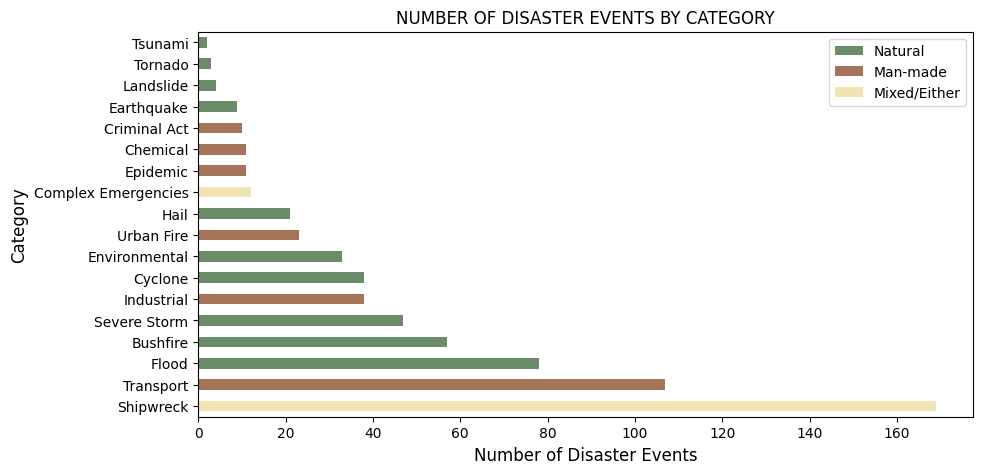

In [724]:
colours = ['#F2E3B3', '#A67458', '#6A8C69', '#6A8C69', '#6A8C69', '#A67458', '#6A8C69', '#6A8C69', '#A67458', '#6A8C69', '#F2E3B3', '#A67458', '#A67458', '#A67458', '#6A8C69', '#6A8C69', '#6A8C69', '#6A8C69']

ddvc = disaster_data.category.value_counts()
ddvc.plot.barh(color=colours)
plt.legend([Patch(facecolor="#6A8C69"),Patch(facecolor="#A67458"),Patch(facecolor="#F2E3B3")], ["Natural", "Man-made", "Mixed/Either"])
plt.title("NUMBER OF DISASTER EVENTS BY CATEGORY", fontsize=12)
plt.xlabel("Number of Disaster Events", fontsize=12)
plt.ylabel("Category", fontsize=12)

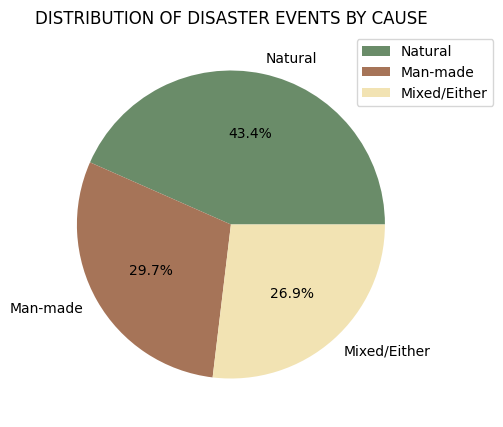

In [725]:
disaster_data.cause.value_counts().plot.pie(autopct="%.1f%%", colors= ["#6A8C69", "#A67458", "#F2E3B3"])
plt.title("DISTRIBUTION OF DISASTER EVENTS BY CAUSE", fontsize=12)
plt.ylabel("", fontsize=15)
plt.legend(bbox_to_anchor= (1.2, 1))

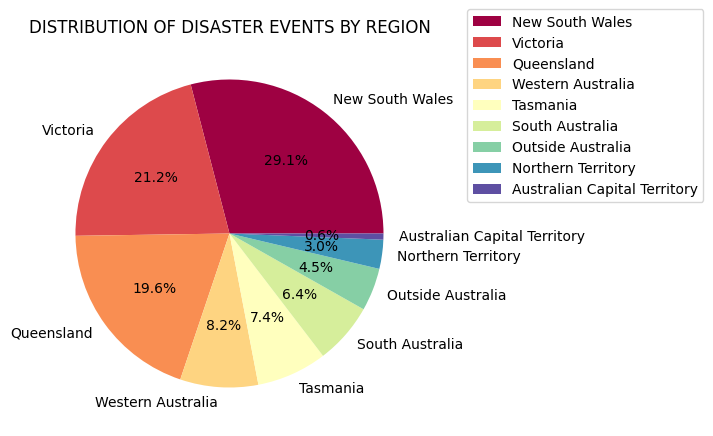

In [726]:
single_regions = disaster_data[disaster_data.regions.str.contains(";") == False]

ddvc = single_regions.regions.value_counts() # This makes a series
ddvc.plot(kind="pie", autopct="%.1f%%", cmap='Spectral')
plt.title("DISTRIBUTION OF DISASTER EVENTS BY REGION", fontsize=12)
plt.ylabel("", fontsize=15)
plt.legend(bbox_to_anchor= (1.1, 1.1))

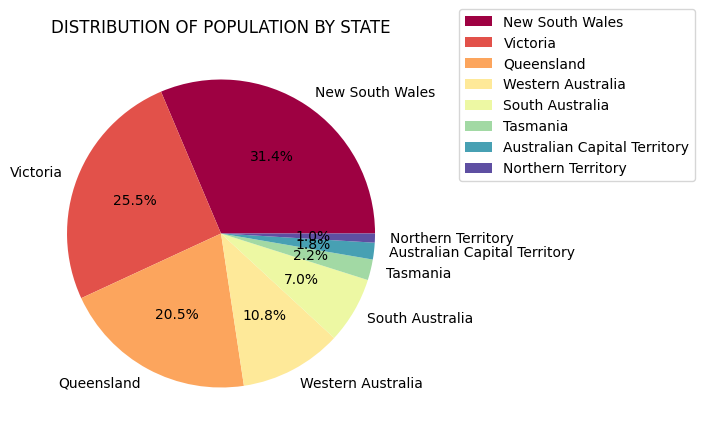

In [727]:
auspopdata = pd.DataFrame({"population": [8238800, 6704300, 5378300, 2825200, 1834300, 571600, 460900, 250100]}, index=["New South Wales", "Victoria", "Queensland", "Western Australia", "South Australia", "Tasmania", "Australian Capital Territory", "Northern Territory"])
auspopdata.plot(kind="pie", y="population", autopct="%.1f%%", cmap='Spectral')
plt.title("DISTRIBUTION OF POPULATION BY STATE", fontsize=12)
plt.ylabel("", fontsize=15)
plt.legend(bbox_to_anchor= (1.1, 1.1))

In [728]:
gdf = gp.GeoDataFrame(disaster_data, geometry=gp.points_from_xy(disaster_data.lon, disaster_data.lat), crs="EPSG:4326"
)

cols_to_drop = ['FID', 'resourcetype', 'description', 'evacuated', 'homeless', 'injuries', 'deaths',
       'insured_cost', 'trains_damaged', 'trains_destroyed', 'homes_damaged',
       'homes_destroyed', 'buildings_damaged', 'buildings_destroyed',
       'ind_premises_destroyed', 'com_premises_damaged',
       'com_premises_destroyed', 'bridges_damaged', 'bridges_destroyed',
       'aircraft_damaged', 'aircraft_destroyed', 'motor_vehicles_damaged',
       'motor_vehicles_destroyed', 'water_vessels_damaged',
       'water_vessels_destroyed', 'businesses_damaged', 'businesses_destroyed',
       'farms_damaged', 'farms_destroyed', 'crops_destroyed',
       'livestock_destroyed', 'government_assistance', 'url', 'the_geom']
gdf.drop(cols_to_drop, axis=1, inplace=True, errors="ignore")
gdf

,id,title,startdate,enddate,lat,lon,regions,start_dt,end_dt,day_of_week,year,duration,duration_in_years,category,cause,geometry
0,3,Industrial - Appin Mine Explosion,1979-07-24,1979-07-24,-34.192211,150.786331,New South Wales,1979-07-24,1979-07-24,Tuesday,1979,0 days,0.000000,Industrial,Man-made,POINT (150.78633 -34.19221)
1,9,Transport - Trawalla Train and Truck Collision,2006-04-28,2006-04-28,-37.436260,143.469421,Victoria,2006-04-28,2006-04-28,Friday,2006,0 days,0.000000,Transport,Man-made,POINT (143.46942 -37.43626)
2,22,Bushfire - Great Divide Complex,2006-12-01,2007-02-07,-36.718010,147.145218,Victoria,2006-12-01,2007-02-07,Friday,2006,68 days,0.186301,Bushfire,Natural,POINT (147.14522 -36.71801)
3,24,Severe Storm - South-East Queensland and North...,2007-10-07,2007-10-12,-28.805798,153.276871,Queensland,2007-10-07,2007-10-12,Sunday,2007,5 days,0.013699,Severe Storm,Natural,POINT (153.27687 -28.80580)
4,38,Shipwreck - Vixen,1847-01-09,1847-01-09,-29.334297,153.369141,Queensland,1847-01-09,1847-01-09,Saturday,1847,0 days,0.000000,Shipwreck,Mixed/Either,POINT (153.36914 -29.33430)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668,4946,"Bushfire - Grampians National Park, Victoria, ...",2014-01-15,2014-01-21,-37.129120,142.519623,Victoria,2014-01-15,2014-01-21,Wednesday,2014,6 days,0.016438,Bushfire,Natural,POINT (142.51962 -37.12912)
669,4960,"Environmental - Heatwave, South-Eastern Austra...",2014-01-11,2014-01-21,-33.284618,140.976562,Queensland;New South Wales;Victoria;South Aust...,2014-01-11,2014-01-21,Saturday,2014,10 days,0.027397,Environmental,Natural,POINT (140.97656 -33.28462)
670,5013,"Flood - Gascoyne River, Western Australia, 2010",2010-12-16,2010-12-20,-24.839088,113.749695,Queensland,2010-12-16,2010-12-20,Thursday,2010,4 days,0.010959,Flood,Natural,POINT (113.74969 -24.83909)
671,5015,"Bushfire - Victoria, 2014",2014-02-09,2014-02-14,-37.564716,144.893189,Victoria,2014-02-09,2014-02-14,Sunday,2014,5 days,0.013699,Bushfire,Natural,POINT (144.89319 -37.56472)


C:\Users\rishi\AppData\Local\Temp\ipykernel_32336\2028151085.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries = gp.read_file(gp.datasets.get_path("naturalearth_lowres"))


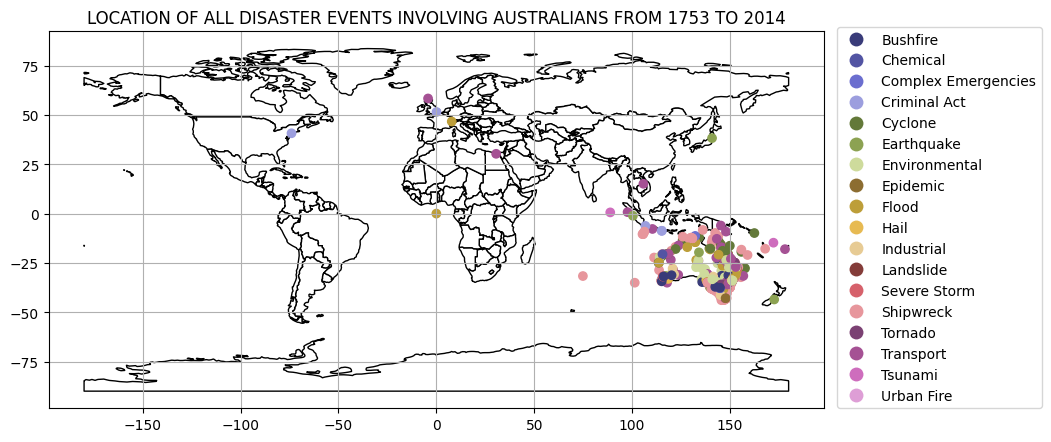

In [729]:
countries = gp.read_file(gp.datasets.get_path("naturalearth_lowres"))
ax = countries.plot(color="white", edgecolor="black")

gdf.plot(ax=ax, column="category", cmap="tab20b", legend=True, legend_kwds={'bbox_to_anchor': (1.29, 1.03)})
plt.title("LOCATION OF ALL DISASTER EVENTS INVOLVING AUSTRALIANS FROM 1753 TO 2014", fontsize=12)
plt.ylabel("", fontsize=15)
plt.grid()
plt.show();

In [730]:
mid_of_aus = shapely.geometry.point.Point(134.298763, -25.002923)
gdf["distance_from_Aus"] = gdf.centroid.distance(mid_of_aus)
close_disasters = gdf[gdf.distance_from_Aus < 40]

C:\Users\rishi\AppData\Local\Temp\ipykernel_32336\1272217206.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["distance_from_Aus"] = gdf.centroid.distance(mid_of_aus)
C:\Users\rishi\AppData\Local\Temp\ipykernel_32336\1272217206.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["distance_from_Aus"] = gdf.centroid.distance(mid_of_aus)


C:\Users\rishi\AppData\Local\Temp\ipykernel_32336\1989244907.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries = gp.read_file(gp.datasets.get_path("naturalearth_lowres"))


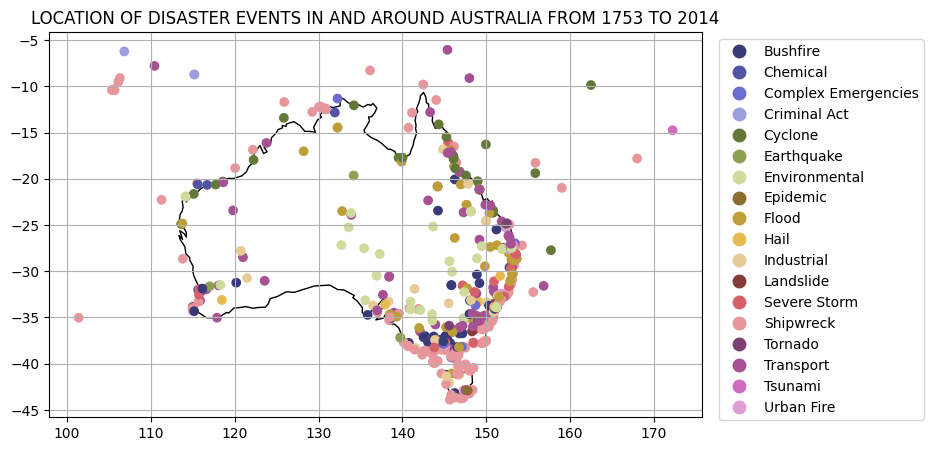

In [731]:
countries = gp.read_file(gp.datasets.get_path("naturalearth_lowres"))
ax = countries[countries["name"] == "Australia"].plot(color="white", edgecolor="black")

close_disasters.plot(ax=ax, column="category", cmap="tab20b", legend=True, legend_kwds={'bbox_to_anchor': (1.35, 1)})
plt.title("LOCATION OF DISASTER EVENTS IN AND AROUND AUSTRALIA FROM 1753 TO 2014", fontsize=12)
plt.ylabel("", fontsize=15)
plt.grid()
plt.show();

C:\Users\rishi\AppData\Local\Temp\ipykernel_32336\4140124864.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries = gp.read_file(gp.datasets.get_path("naturalearth_lowres"))
C:\Users\rishi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


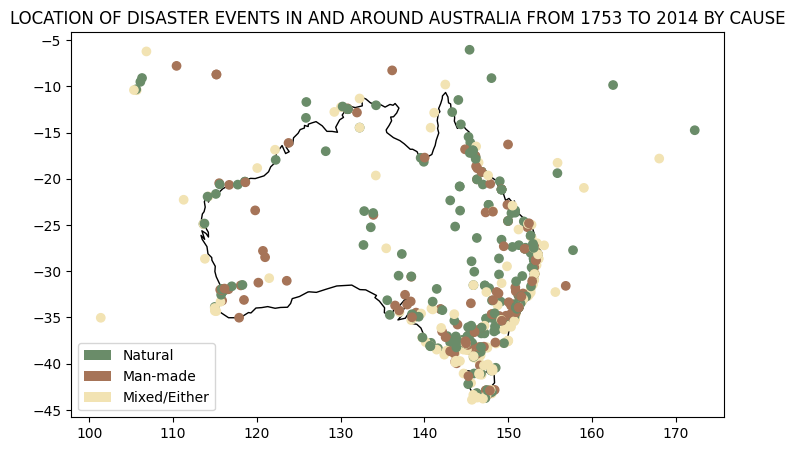

In [732]:
colours= {"Natural": "#6A8C69", "Man-made":"#A67458", "Mixed/Either": "#F2E3B3"}
countries = gp.read_file(gp.datasets.get_path("naturalearth_lowres"))
ax = countries[countries["name"] == "Australia"].plot(color="white", edgecolor="black")

close_disasters.plot(ax=ax, column="cause", color=disaster_data['cause'].replace(colours), legend=True, legend_kwds={'bbox_to_anchor': (1.35, 1)})
plt.legend([Patch(facecolor="#6A8C69"),Patch(facecolor="#A67458"),Patch(facecolor="#F2E3B3")], ["Natural", "Man-made", "Mixed/Either"])
plt.title("LOCATION OF DISASTER EVENTS IN AND AROUND AUSTRALIA FROM 1753 TO 2014 BY CAUSE", fontsize=12)
plt.ylabel("", fontsize=15)
plt.show();

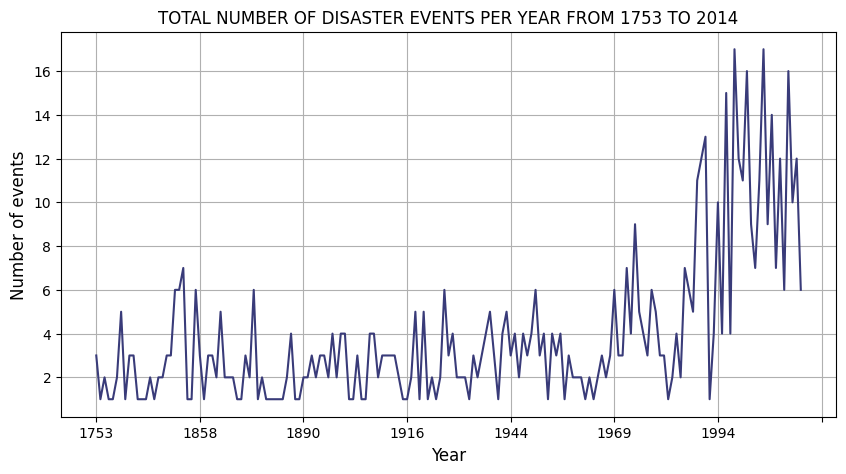

In [733]:
yearly_events = disaster_data.groupby("year").size()
yearly_events.plot(kind="line", cmap='tab20b')

plt.title("TOTAL NUMBER OF DISASTER EVENTS PER YEAR FROM 1753 TO 2014", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of events", fontsize=12)
plt.grid()
plt.show();

In [734]:
sliced_dd = disaster_data.set_index('start_dt').sort_index().loc['1900-01-01' : '2014-12-31', :] 
sliced_dd.head()

,FID,id,resourcetype,title,description,startdate,enddate,lat,lon,evacuated,...,regions,url,the_geom,end_dt,day_of_week,year,duration,duration_in_years,category,cause
start_dt,,,,,,,,,,,,,,,,,,,,,
1900-01-19,disaster_events_impact_location.fid-2393c2e0_1...,194,Disaster Event,Epidemic - Bubonic Plague Sydney,"Between 1900 and 1925, there were 12 major pla...",1900-01-19,1925-01-01,-33.874977,151.215820,0.0,...,Queensland;New South Wales;South Australia;Wes...,http://www.emknowledge.gov.au/resource/?id=194,POINT (-33.87497711 151.2158203),1925-01-01,Friday,1900,9113 days,24.967123,Epidemic,Man-made
1900-03-17,disaster_events_impact_location.fid-2393c2e0_1...,4415,Disaster Event,Industrial - Balmain Colliery 1900,"On 17 March 1900, six men were being lowered d...",1900-03-17,1900-03-17,-33.856731,151.181168,0.0,...,New South Wales,http://www.emknowledge.gov.au/resource/?id=4415,POINT (-33.85673141 151.1811676),1900-03-17,Saturday,1900,0 days,0.000000,Industrial,Man-made
1900-05-09,disaster_events_impact_location.fid-2393c2e0_1...,216,Disaster Event,Shipwreck - Sierra Nevada,The Sierra Nevada was an iron ship. It wrecked...,1900-05-09,1900-05-09,-38.335060,144.683929,0.0,...,Victoria,http://www.emknowledge.gov.au/resource/?id=216,POINT (-38.33506012 144.6839294),1900-05-09,Wednesday,1900,0 days,0.000000,Shipwreck,Mixed/Either
1900-12-05,disaster_events_impact_location.fid-2393c2e0_1...,291,Disaster Event,Industrial - Greta Colliery Fire,"On 5 December 1900 at approximately 11 pm, a f...",1900-12-05,1900-12-05,-32.645157,151.390228,0.0,...,New South Wales,http://www.emknowledge.gov.au/resource/?id=291,POINT (-32.64515686 151.3902283),1900-12-05,Wednesday,1900,0 days,0.000000,Industrial,Man-made
1901-02-15,disaster_events_impact_location.fid-2393c2e0_1...,185,Disaster Event,Transport - Sydenham Train Derailment,"On 15 February 1901, a railway accident occurr...",1901-02-15,1901-02-15,-33.924034,151.156509,0.0,...,New South Wales,http://www.emknowledge.gov.au/resource/?id=185,POINT (-33.92403412 151.1565094),1901-02-15,Friday,1901,0 days,0.000000,Transport,Man-made


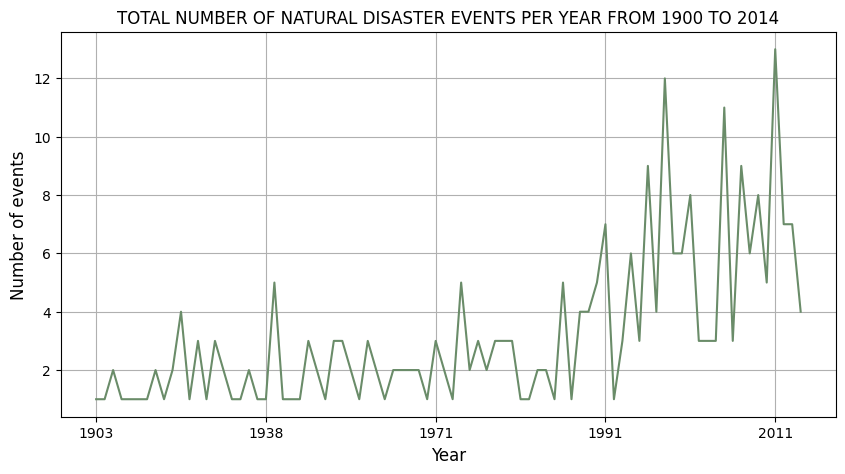

In [735]:
sliced_dd[sliced_dd.cause == "Natural"].groupby("year").size().plot(kind="line", color="#6A8C69")

plt.title("TOTAL NUMBER OF NATURAL DISASTER EVENTS PER YEAR FROM 1900 TO 2014", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of events", fontsize=12)
plt.grid()
plt.show();


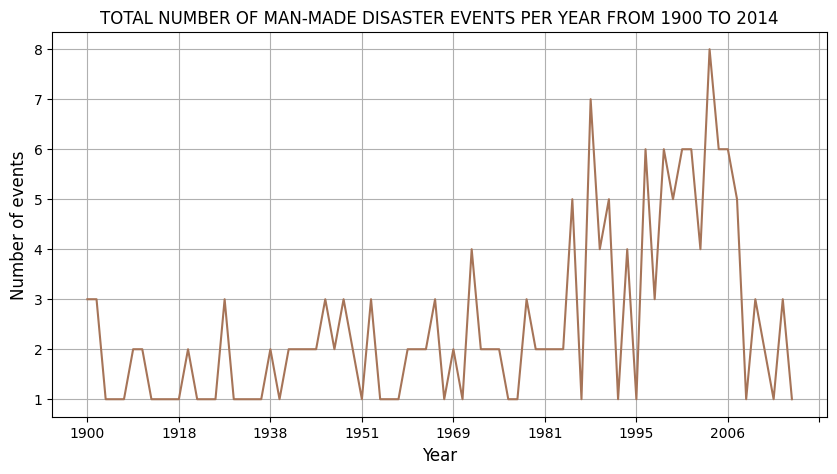

In [736]:
sliced_dd[sliced_dd.cause == "Man-made"].groupby("year").size().plot(kind="line", color="#A67458")

plt.title("TOTAL NUMBER OF MAN-MADE DISASTER EVENTS PER YEAR FROM 1900 TO 2014", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of events", fontsize=12)
plt.grid()
plt.show();


C:\Users\rishi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\plotting\_matplotlib\core.py:1256: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='deaths', ylabel='injuries'>

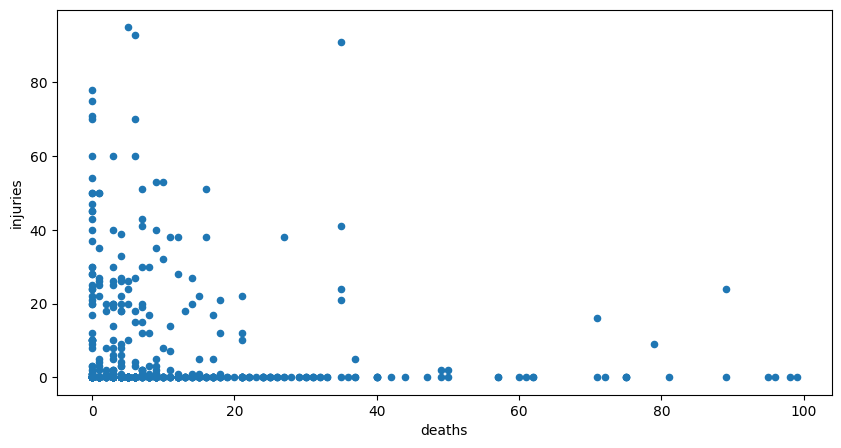

In [737]:
disaster_data[(disaster_data.deaths < 100) & (disaster_data.injuries < 100)].plot.scatter(x='deaths', y='injuries', cmap='tab20b')

Deaths by Category:

Text(0.5, 0, 'Number of Deaths')

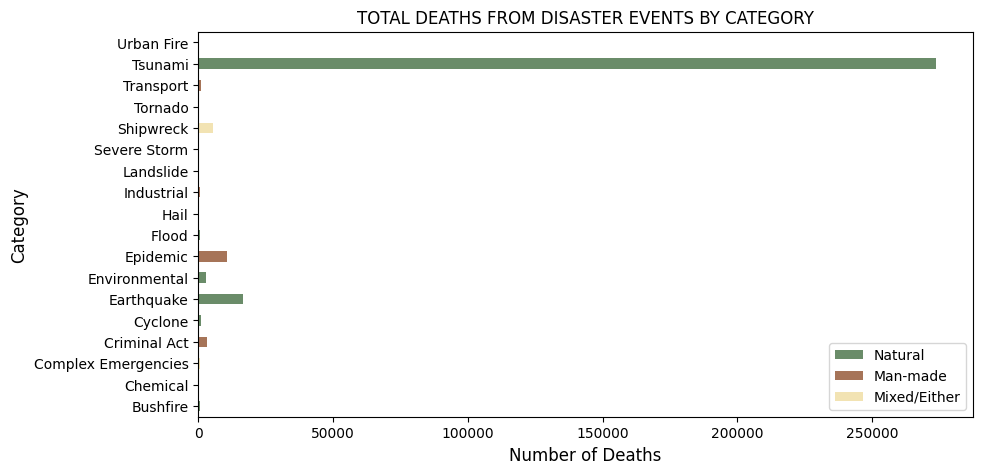

In [738]:
colours = ['#6A8C69', '#A67458', '#F2E3B3', '#A67458', '#6A8C69', '#6A8C69', '#6A8C69', '#A67458', '#6A8C69', '#6A8C69', '#A67458', '#6A8C69', '#6A8C69', '#F2E3B3', '#6A8C69', '#A67458', '#6A8C69', '#A67458']
deaths = disaster_data.groupby(['category']).deaths.sum().plot(kind='barh', color=colours)
plt.legend([Patch(facecolor="#6A8C69"),Patch(facecolor="#A67458"),Patch(facecolor="#F2E3B3")], ["Natural", "Man-made", "Mixed/Either"])
plt.title("TOTAL DEATHS FROM DISASTER EVENTS BY CATEGORY", fontsize=12)
plt.ylabel("Category", fontsize=12)
plt.xlabel("Number of Deaths", fontsize=12)

In [739]:
top_deaths = disaster_data.sort_values('deaths', ascending=False).head(5)
top_deaths[['title','start_dt', 'deaths']]



,title,start_dt,deaths
411,Tsunami - Indian Ocean,2004-12-26,273636.0
526,Earthquake - Japan,2011-03-11,15467.0
138,Epidemic - Spanish Flu,1918-01-01,10000.0
419,Criminal Act - 9/11 Terrorist Attacks,2001-09-11,2819.0
505,Earthquake - Sumatra,2009-09-30,1117.0


Text(0.5, 0, 'Number of Deaths')

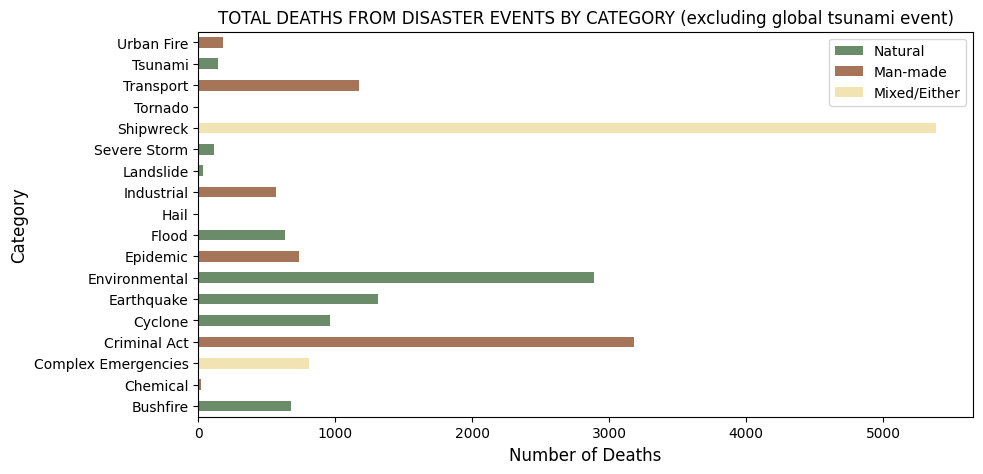

In [740]:
colours = ['#6A8C69', '#A67458', '#F2E3B3', '#A67458', '#6A8C69', '#6A8C69', '#6A8C69', '#A67458', '#6A8C69', '#6A8C69', '#A67458', '#6A8C69', '#6A8C69', '#F2E3B3', '#6A8C69', '#A67458', '#6A8C69', '#A67458']
deaths = disaster_data[(disaster_data.deaths < 5000)].groupby(['category']).deaths.sum().plot(kind='barh', color=colours)
plt.legend([Patch(facecolor="#6A8C69"),Patch(facecolor="#A67458"),Patch(facecolor="#F2E3B3")], ["Natural", "Man-made", "Mixed/Either"])
plt.title("TOTAL DEATHS FROM DISASTER EVENTS BY CATEGORY (excluding global tsunami event)", fontsize=12)
plt.ylabel("Category", fontsize=12)
plt.xlabel("Number of Deaths", fontsize=12)

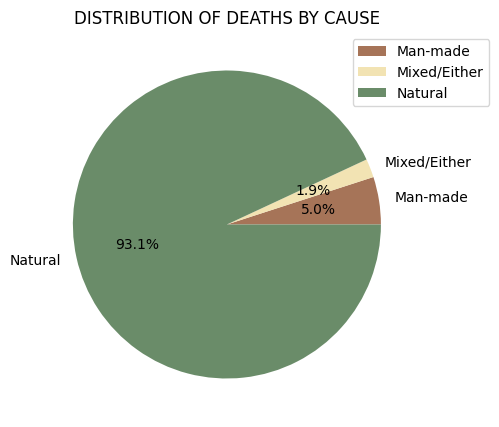

In [741]:
disaster_data.groupby(["cause"]).deaths.sum().plot(kind="pie", autopct="%.1f%%", colors= ["#A67458", "#F2E3B3", "#6A8C69"])
plt.title("DISTRIBUTION OF DEATHS BY CAUSE", fontsize=12)
plt.ylabel("", fontsize=15)
plt.legend(bbox_to_anchor= (1.2, 1))

Text(0.5, 0, 'Number of Injuries')

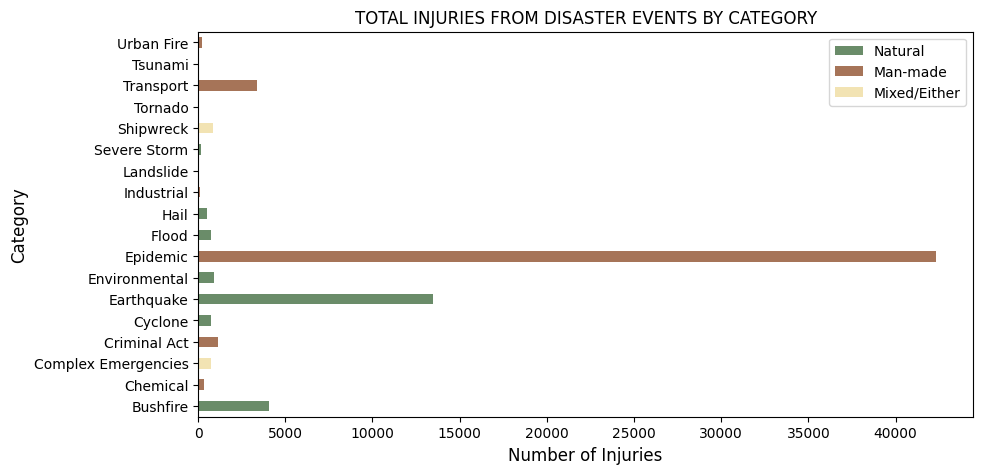

In [742]:
colours = ['#6A8C69', '#A67458', '#F2E3B3', '#A67458', '#6A8C69', '#6A8C69', '#6A8C69', '#A67458', '#6A8C69', '#6A8C69', '#A67458', '#6A8C69', '#6A8C69', '#F2E3B3', '#6A8C69', '#A67458', '#6A8C69', '#A67458']
injuries = disaster_data.groupby(['category']).injuries.sum().plot(kind='barh', color=colours)
plt.legend([Patch(facecolor="#6A8C69"),Patch(facecolor="#A67458"),Patch(facecolor="#F2E3B3")], ["Natural", "Man-made", "Mixed/Either"])
plt.title("TOTAL INJURIES FROM DISASTER EVENTS BY CATEGORY", fontsize=12)
plt.ylabel("Category", fontsize=12)
plt.xlabel("Number of Injuries", fontsize=12)

In [743]:
top_injuries = disaster_data.sort_values('injuries', ascending=False).head(5)
top_injuries[['title','start_dt', 'injuries']]

,title,start_dt,injuries
285,Epidemic - Poliomyelitis,1930-01-01,40000.0
628,"Earthquake - Christchurch, New Zealand",2011-02-22,6659.0
526,Earthquake - Japan,2011-03-11,5388.0
171,Bushfire - Ash Wednesday,1983-02-16,1500.0
2,Bushfire - Great Divide Complex,2006-12-01,1400.0


Text(0.5, 0, 'Number of Injuries')

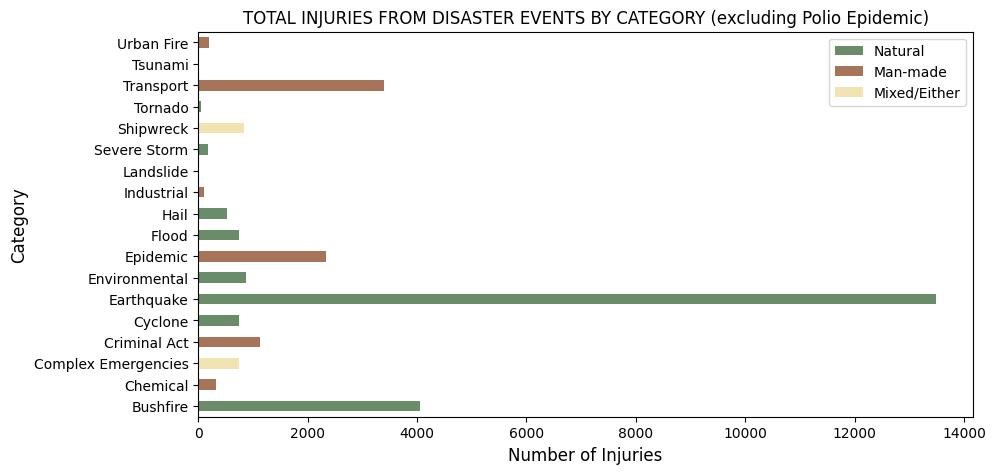

In [744]:
colours = ['#6A8C69', '#A67458', '#F2E3B3', '#A67458', '#6A8C69', '#6A8C69', '#6A8C69', '#A67458', '#6A8C69', '#6A8C69', '#A67458', '#6A8C69', '#6A8C69', '#F2E3B3', '#6A8C69', '#A67458', '#6A8C69', '#A67458']
injuries = disaster_data[(disaster_data.injuries < 10000)].groupby(['category']).injuries.sum().plot(kind='barh', color=colours)
plt.legend([Patch(facecolor="#6A8C69"),Patch(facecolor="#A67458"),Patch(facecolor="#F2E3B3")], ["Natural", "Man-made", "Mixed/Either"])
plt.title("TOTAL INJURIES FROM DISASTER EVENTS BY CATEGORY (excluding Polio Epidemic)", fontsize=12)
plt.ylabel("Category", fontsize=12)
plt.xlabel("Number of Injuries", fontsize=12)

Text(0, 0.5, 'Insured Cost($)')

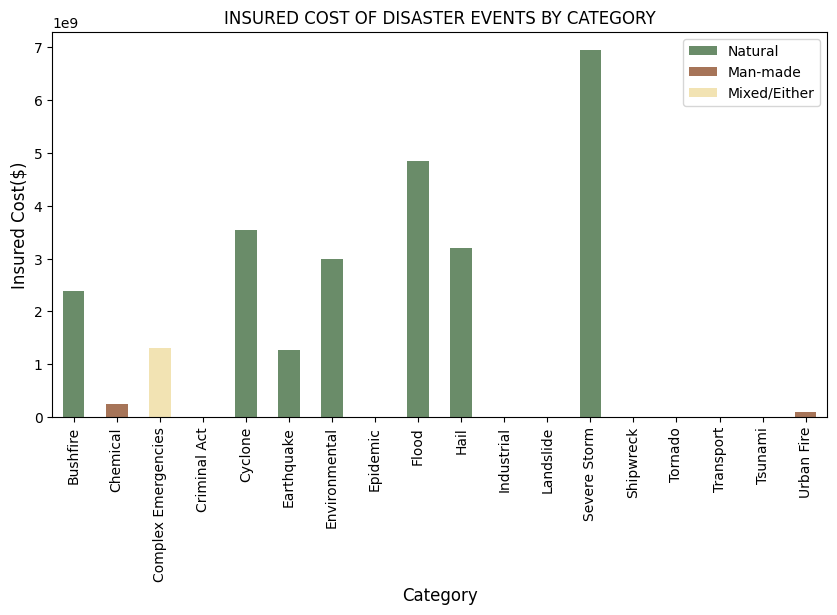

In [745]:
colours = ['#6A8C69', '#A67458', '#F2E3B3', '#A67458', '#6A8C69', '#6A8C69', '#6A8C69', '#A67458', '#6A8C69', '#6A8C69', '#A67458', '#6A8C69', '#6A8C69', '#F2E3B3', '#6A8C69', '#A67458', '#6A8C69', '#A67458']
injuries = disaster_data.groupby(['category']).insured_cost.sum().plot(kind='bar', color=colours)
plt.legend([Patch(facecolor="#6A8C69"),Patch(facecolor="#A67458"),Patch(facecolor="#F2E3B3")], ["Natural", "Man-made", "Mixed/Either"])
plt.title("INSURED COST OF DISASTER EVENTS BY CATEGORY", fontsize=12)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Insured Cost($)", fontsize=12)

In [746]:
top_cost = disaster_data.sort_values('insured_cost', ascending=False).head(5)
top_cost[['title','start_dt', 'insured_cost']]

,title,start_dt,insured_cost
136,Environmental - Eastern Australia Drought,1982-04-01,3.000000e+09
29,Flood - Queensland Nov 2010,2010-11-30,2.380000e+09
249,Hail - Sydney Apr 1999,1999-04-14,1.700000e+09
63,Severe Storm - New South Wales East Coast Low,2007-06-08,1.480000e+09
519,"Cyclone Yasi, Queensland, 2011",2011-02-03,1.412000e+09


Text(0, 0.5, 'Insured Cost($)')

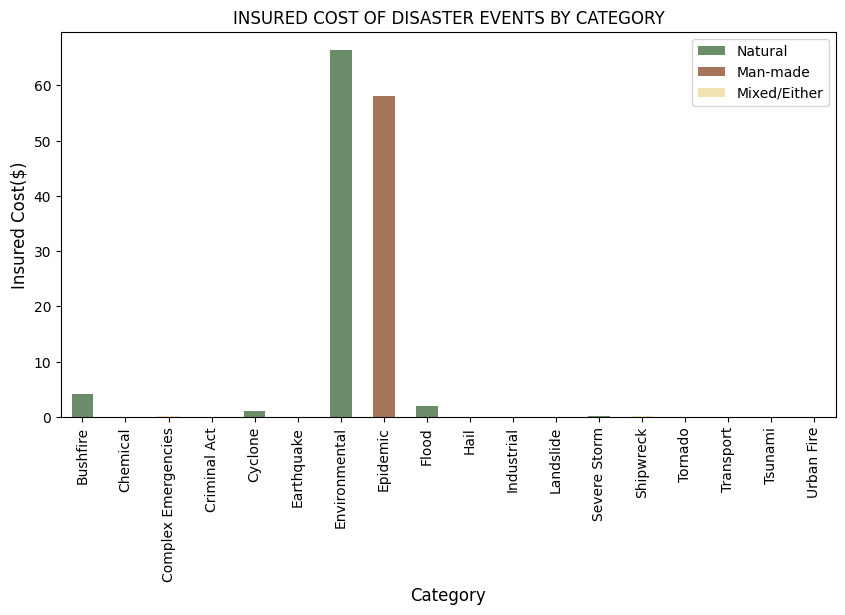

In [747]:
colours = ['#6A8C69', '#A67458', '#F2E3B3', '#A67458', '#6A8C69', '#6A8C69', '#6A8C69', '#A67458', '#6A8C69', '#6A8C69', '#A67458', '#6A8C69', '#6A8C69', '#F2E3B3', '#6A8C69', '#A67458', '#6A8C69', '#A67458']
duration = disaster_data.groupby(['category']).duration_in_years.sum().plot(kind='bar', color=colours)
plt.legend([Patch(facecolor="#6A8C69"),Patch(facecolor="#A67458"),Patch(facecolor="#F2E3B3")], ["Natural", "Man-made", "Mixed/Either"])
plt.title("INSURED COST OF DISASTER EVENTS BY CATEGORY", fontsize=12)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Insured Cost($)", fontsize=12)

In [748]:
top_longest = disaster_data.sort_values('duration', ascending=False).head(5)
top_longest[['title','start_dt', 'end_dt', 'duration', "duration_in_years"]]

,title,start_dt,end_dt,duration,duration_in_years
285,Epidemic - Poliomyelitis,1930-01-01,1959-01-01,10592 days,29.019178
230,Epidemic - Bubonic Plague Sydney,1900-01-19,1925-01-01,9113 days,24.967123
45,Environmental - The Big Dry,1996-01-01,2012-04-01,5935 days,16.260274
351,Environmental - National Drought,1958-01-01,1968-09-01,3896 days,10.673973
309,Environmental - Federation Drought,1895-01-01,1902-01-01,2556 days,7.002740


Text(0, 0.5, 'Duration (years)')

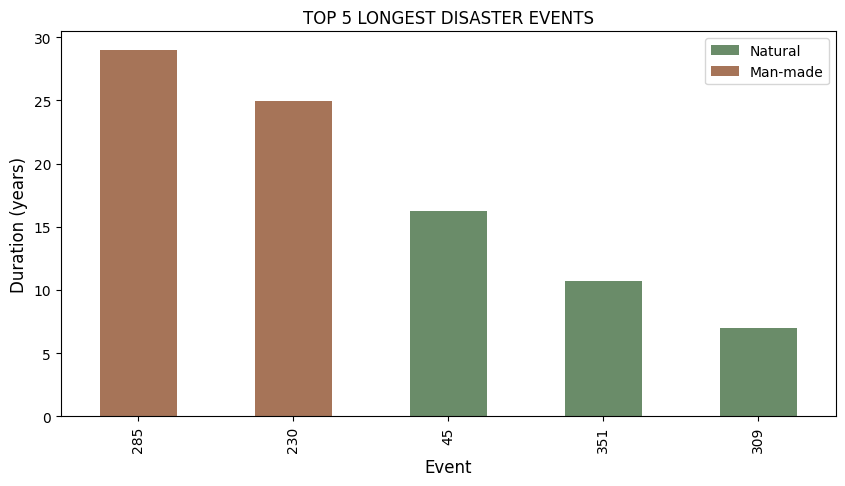

In [754]:
colours = ['#A67458', '#A67458', '#6A8C69', '#6A8C69', '#6A8C69']
top_longest.duration_in_years.plot.bar(color=colours)
plt.legend([Patch(facecolor="#6A8C69"),Patch(facecolor="#A67458")], ["Natural", "Man-made"])
plt.title("TOP 5 LONGEST DISASTER EVENTS", fontsize=12)
plt.xlabel("Event", fontsize=12)
plt.ylabel("Duration (years)", fontsize=12)

Events by Day of the Week:

<Axes: ylabel='day_of_week'>

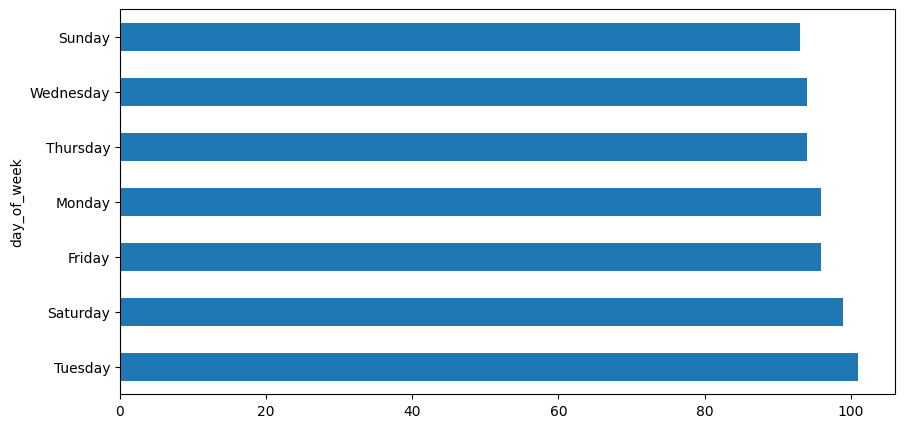

In [410]:
disaster_data.day_of_week.value_counts().plot(kind="barh")

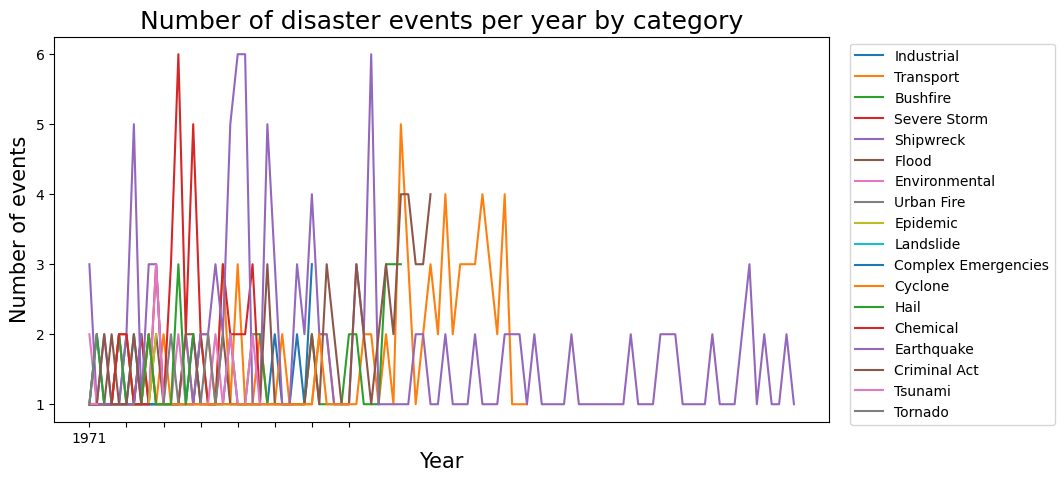

In [413]:
fig, ax= plt.subplots()

for category in disaster_data['category'].unique():
    yearly_events_category = disaster_data[disaster_data.category == category].groupby("year").size()
    yearly_events_category.plot.line(ax=ax, label=category)

plt.title("Number of disaster events per year by category", fontsize=18)
plt.xlabel("Year", fontsize=15)
plt.ylabel("Number of events", fontsize=15)
plt.legend(bbox_to_anchor= (1.3, 1))
plt.show()